In [1]:
import requests
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imutils
from IPython.display import Image, display

In [2]:
class Camera:
    def __init__(self, name, lat, lon, image_url, video_url, img_timestamp, video_timestamp):
        self.name = name
        self.lat = lat
        self.lon = lon
        self.image_url = image_url
        self.video_url = video_url
        self.img_timestamp = img_timestamp
        self.video_timestamp = video_timestamp
        
    def __repr__(self):
        return f"{self.name}: ({self.lat}/{self.lon})"

In [3]:
def all_jam_cams():
    r = requests.get("https://api.tfl.gov.uk/Place/Type/JamCam")
    cams = []
    
    for cam in r.json():
        name = cam['commonName']
        lat = cam['lat']
        lon = cam['lon']
        image_url = None
        image_ts = None
        video_url = None
        video_ts = None
        
        properties = cam['additionalProperties']
        for prop in properties:
            if prop['key'] == 'imageUrl':
                image_url = prop['value']
                image_ts = prop['modified']
            elif prop['key'] == 'videoUrl':
                video_url = prop['value']
                video_ts = prop['modified']
        cams.append(
            Camera(name, lat, lon, image_url, video_url, image_ts, video_ts)
        )
    return cams

In [4]:
cams = all_jam_cams()

### Try to count vehicles

https://medium.com/analytics-vidhya/moving-car-detection-from-video-by-using-computer-vision-e285db894249
https://opencv-tutorial.readthedocs.io/en/latest/yolo/yolo.html

In [5]:
def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

In [6]:
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

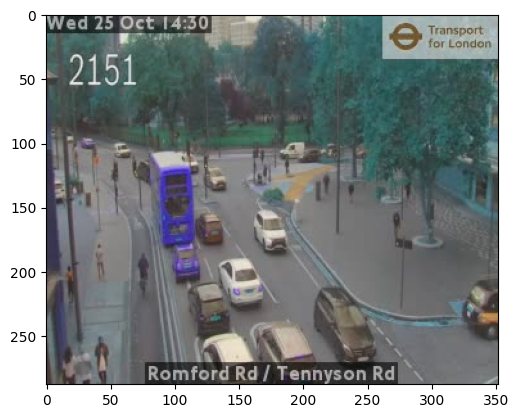

In [7]:
cam = cams[1]

image = imutils.url_to_image(cam.image_url)
plt.imshow(image)

In [21]:
Width = image.shape[1]
Height = image.shape[0]
scale = 1/255 # scale pixel values to [0,1]

# read class names from text file
classes = None
with open('yolo/yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# generate different colors for different classes
colors = np.random.uniform(0, 255, size=(len(classes), 3))
net = cv2.dnn.readNet('yolo/yolov3.weights', 'yolo/yolov3.cfg')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV) # can I use a gpu here?

# create input blob 
#blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)
blob = cv2.dnn.blobFromImage(image, scale, (Width,Height), swapRB=True, crop=False)

# determine the output layer
ln = net.getLayerNames()
ln = [ln[i-1] for i in net.getUnconnectedOutLayers()]

net.setInput(blob)
outputs = net.forward(ln)

In [22]:
boxes = []
confidences = []
classIDs = []

for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > 0.5:
            box = detection[:4] * np.array([Width, Height, Width, Height])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

In [23]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

In [27]:
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)